In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pkg_resources import resource_filename
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

the published results

In [2]:
#becker13 
b13 = np.load('/Users/jsmonzon/lbg_da/tau_data/literature/Becker_2013.npy')
#schaye03
s03 = np.load('/Users/jsmonzon/lbg_da/tau_data/literature/Schaye_2003.npy')
#kirkman05
k05 = np.load('/Users/jsmonzon/lbg_da/tau_data/literature/Kirkman_2005.npy')

In [3]:
#0.1607 +- .012

In [4]:
all_z = np.concatenate([s03[0,:], k05[0,:], b13[0,:]])
all_tau = np.concatenate([s03[1,:], k05[1,:], b13[1,:]])
all_sig = np.concatenate([s03[2,:], k05[2,:], b13[2,:]])

In [5]:
m20 = np.load('/Users/jsmonzon/lbg_da/tau_data/tau.npy')

In [6]:
all_z = np.concatenate([s03[0,:], k05[0,:], b13[0,:], m20[0,:]])
all_tau = np.concatenate([s03[1,:], k05[1,:], b13[1,:], m20[1,:]])
all_sig = np.concatenate([s03[2,:], k05[2,:], b13[2,:], m20[2,:]])

In [7]:
# Cut
gdz = all_z < 4.0
cut = gdz
all_z = all_z[cut]
all_tau = all_tau[cut]
all_sig = all_sig[cut]

In [8]:
X = np.atleast_2d(all_z).T
X.shape

(180, 1)

In [9]:
# Remove the mean
mean_tau = np.mean(all_tau)
norm_tau = all_tau - mean_tau

In [10]:
scale_z = 100.
scale_tau = 100.
#
scale_z = 1.
scale_tau = 1.

In [11]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(0.1, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9,
                             alpha=all_sig**2)

In [12]:
gp.fit(X*scale_z, norm_tau*scale_tau)

GaussianProcessRegressor(alpha=array([2.56000000e-04, 2.56000000e-04, 6.76000000e-04, 6.76000000e-04,
       1.08900000e-03, 3.61000000e-04, 3.61000000e-04, 6.76000000e-04,
       7.29000000e-04, 3.24000000e-04, 4.41000000e-04, 3.24000000e-04,
       1.96000000e-04, 4.41000000e-04, 3.61000000e-04, 4.84000000e-04,
       4.00000000e-04, 8.41000000e-04, 6.25000000e-04, 4.84000000e-04,
       8.41000000e-...
       2.50170995e-03, 2.31747225e-03, 2.14734857e-03, 1.42142208e-03,
       2.55030371e-03, 2.16025115e-03, 1.30968866e-03, 1.47880498e-03,
       1.41538765e-03, 1.60314285e-03, 1.86148725e-03, 1.59632595e-03,
       2.18957322e-03, 1.66519988e-03, 1.83252039e-03, 1.31675609e-03]),
                         copy_X_train=True, kernel=1**2 * RBF(length_scale=0.1),
                         n_restarts_optimizer=9, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [13]:
#prediction
x = np.atleast_2d(np.linspace(1.4, 4.1, 1000)).T
y_pred, sigma = gp.predict(x*scale_z, return_std=True)

In [14]:
# GP
xv = x[:,0]

# Fill between
x2 = xv[::-1]
xp = np.hstack((xv, x2))
y2 = y_pred-sigma+mean_tau
y2 = y2[::-1]
yp = np.hstack((y_pred+sigma+mean_tau,y2))

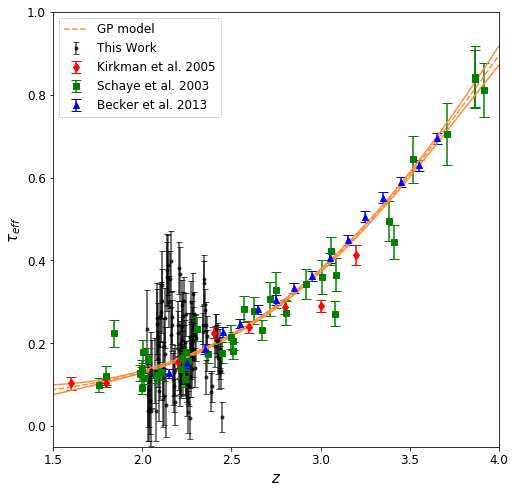

In [15]:
# Plot
plt.figure(figsize=(8,8))

plt.errorbar(m20[0,:], m20[1,:], yerr=m20[2,:], fmt=".", label="This Work",color="black", capsize=3, alpha = .7)
#plt.errorbar(2.2, .16, yerr=.012, color="black", marker="*", markersize=20)

plt.errorbar(k05[0,:], k05[1,:], yerr = k05[2,:],
             capsize=5,label="Kirkman et al. 2005",
             ls="none",color="red", marker="d")
                 
plt.errorbar(s03[0,:], s03[1,:], yerr = s03[2,:],
             capsize=5,label="Schaye et al. 2003",
             ls="none",color="green", marker="s")  
            

plt.errorbar(b13[0,:], b13[1,:], yerr = b13[2,:],
             capsize=5,label="Becker et al. 2013",
             ls="none",color="blue", marker="^")

plt.plot(x[:,0], (y_pred+mean_tau)/scale_tau, color='#fd8d3c', label='GP model', ls="--")
plt.plot(xp, yp, color="#fd8d3c")

plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(-.05, 1.0)
plt.xlim(1.5, 4.0)
plt.xlabel("$z$",fontsize=15)
plt.ylabel("$τ_{eff}$",fontsize=15)
plt.savefig("/Users/jsmonzon/lbg_da/figures/gaussian_model.pdf")
plt.show()